In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

# Фиксируем "случайность" для воспроизводимости
np.random.seed(42)

# Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)

## Загрузите данные: ratings.csv, books.csv, tags.csv, book_tags.csv.

In [2]:

# kagglehub.dataset_download("zygmunt/goodbooks-10k")

# # Проверим, что внутри
# for file in os.listdir(path):
#     print(file)

In [ ]:
path = '.'

dtypes_books: Dict[str, str] = {
    'book_id': 'int16',
    'books_count': 'int16',
    'average_rating': 'float16',
    'ratings_count': 'int32',
    'work_ratings_count': 'int32',
    'work_text_reviews_count': 'int32',
    'ratings_1': 'int32',
    'ratings_2': 'int32',
    'ratings_3': 'int32',
    'ratings_4': 'int32',
    'ratings_5': 'int32'
}

dtypes_ratings: Dict[str, str] = {
    'book_id': 'int16',
    'user_id': 'uint16',
    'rating': 'int8'
}

# Загружаем с явным указанием типа
book_tags = pd.read_csv(path + '/book_tags.csv',
                        dtype={'goodreads_book_id': 'int16', 'tag_id': 'int16', 'count': 'int32'})
ratings = pd.read_csv(path + '/ratings.csv', dtype=dtypes_ratings)  # type: ignore
tags = pd.read_csv(path + '/tags.csv', dtype={'tag_id': 'int16', 'tag_name': 'category'})
books = pd.read_csv(path + '/books.csv', dtype=dtypes_books)  # type: ignore


# Удаляем лишнии колонки
books = books.drop(['small_image_url', 'image_url', 'isbn', 'isbn13'], axis=1)

# Документация по датасетам книг

## Обзор датасетов

| Датасет | Назначение |
|---------|------------|
| `books` | Основная информация о книгах
| `ratings` | Рейтинги пользователей
| `tags` | Теги/категории книг
| `book_tags` | Связь книг с тегами


## books - Основная информация о книгах

| Поле | Описание |
|------|----------|
| `book_id` | Идентификатор книги в системе |
| `best_book_id` | Идентификатор лучшего издания книги |
| `work_id` | Идентификатор произведения |
| `books_count` | Количество изданий книги |
| `authors` | Автор(ы) книги |
| `original_publication_year` | Год первой публикации |
| `original_title` | Оригинальное название |
| `title` | Название на языке издания |
| `language_code` | Код языка издания |
| `average_rating` | Средний рейтинг |
| `ratings_count` | Общее количество оценок |
| `work_ratings_count` | Количество оценок произведения |
| `work_text_reviews_count` | Количество текстовых рецензий |
| `ratings_1` | Количество оценок 1 звезда |
| `ratings_2` | Количество оценок 2 звезды |
| `ratings_3` | Количество оценок 3 звезды |
| `ratings_4` | Количество оценок 4 звезды |
| `ratings_5` | Количество оценок 5 звезд |



## ratings - Оценки пользователей

| Поле | Описание |
|------|----------|
| `book_id` | Идентификатор книги (внешний ключ) |
| `user_id` | Идентификатор пользователя |
| `rating` | Оценка (вероятно, от 1 до 5) |



## tags - Словарь тегов

| Поле | Описание |
|------|---------|
| `tag_id` | Уникальный идентификатор тега |
| `tag_name` | Название тега/категории |



## book_tags - Связь книг с тегами

| Поле | Описание |
|------|----------|
| `goodreads_book_id` | Идентификатор книги в Goodreads |
| `tag_id` | Идентификатор тега (внешний ключ) |
| `count` | Количество раз, которое тег был присвоен книге |

In [4]:
book_tags.info(),
ratings.info(),
tags.info(),
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int16
 1   tag_id             999912 non-null  int16
 2   count              999912 non-null  int32
dtypes: int16(2), int32(1)
memory usage: 7.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  uint16
 1   book_id  int16 
 2   rating   int8  
dtypes: int16(1), int8(1), uint16(1)
memory usage: 28.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tag_id    34252 non-null  int16   
 1   tag_name  34252 non-null  category
dtypes: category(1), int16(1)
memory usage: 468.4 KB
<class 'pa

In [5]:
# Объединяем book_tags с tags чтобы получить названия тегов
tags_with_names = book_tags.merge(tags, on='tag_id', how='left')

# Группируем по goodreads_book_id и собираем все теги в список
book_tags_grouped = tags_with_names.groupby('goodreads_book_id')['tag_name'] \
    .apply(list) \
    .reset_index(name='tags_list')

# Объединяем с исходным DataFrame
books_with_tags = books.merge(book_tags_grouped, on='goodreads_book_id', how='left')

# Объединяем книги с рейтингами
df = pd.merge(books_with_tags, ratings, on='book_id')
df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tags_list,user_id,rating
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,2886,5
1,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,6158,5
2,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,3991,4
3,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5281,5
4,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5721,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976474,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",35336,4
5976475,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",17999,3
5976476,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",49007,4
5976477,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",43319,5


In [6]:
# # Добавляем теги
df_tags = pd.merge(
    books,
    pd.merge(book_tags, tags, on='tag_id'),
    left_on='goodreads_book_id',
    right_on='goodreads_book_id'
)
df_tags

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tag_id,count,tag_name
0,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,30574,496107,to-read
1,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,11557,48220,favorites
2,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,11305,47478,fantasy
3,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,8717,44640,currently-reading
4,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,-32422,14984,young-adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228195,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,14612,3,history-politics
228196,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,-32731,3,world-war
228197,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,32156,3,war-ww1
228198,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,20285,3,modern-european-history


In [7]:
df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tags_list,user_id,rating
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,2886,5
1,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,6158,5
2,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,3991,4
3,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5281,5
4,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5721,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976474,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",35336,4
5976475,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",17999,3
5976476,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",49007,4
5976477,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",43319,5


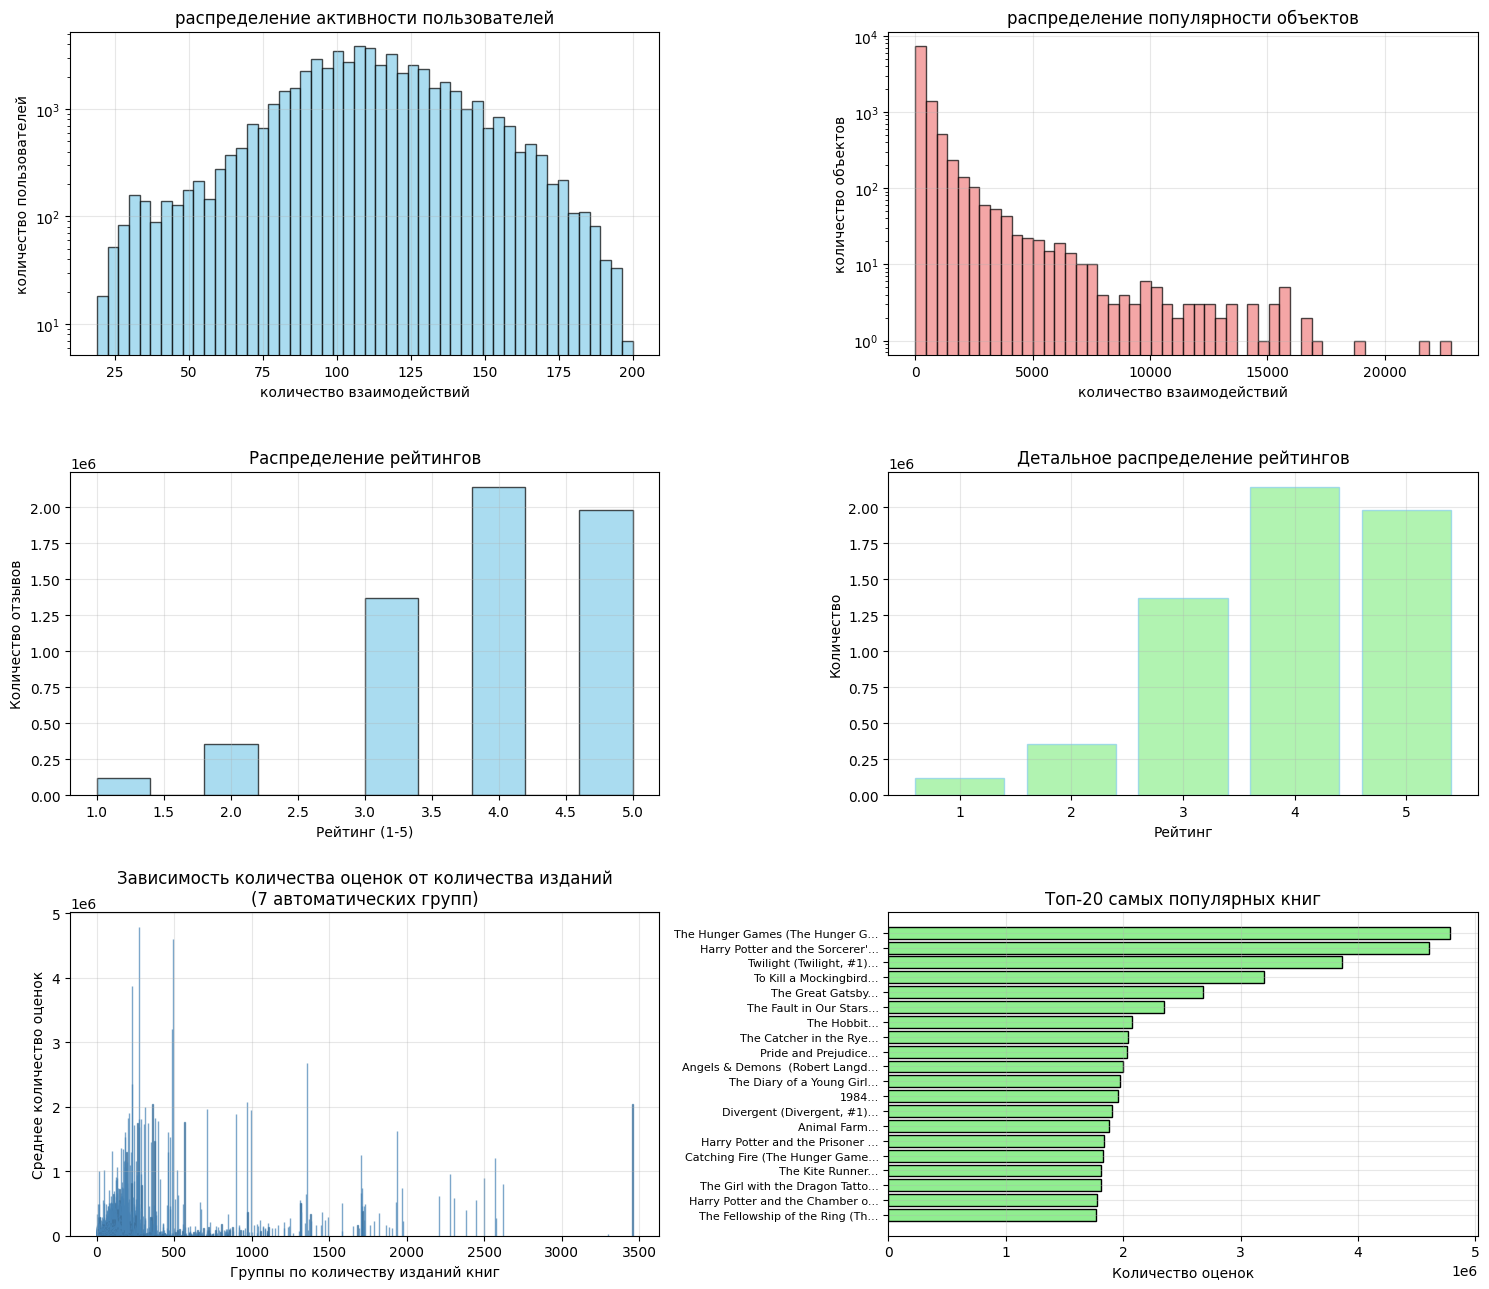

ОСНОВНАЯ СТАТИСТИКА:
уникальных пользователей: 53,424
уникальных объектов: 10,000
всего взаимодействий: 5,976,479
разреженность матрицы: 98.8813%

АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:
среднее: 111.9
медиана: 111.0
максимум: 200
пользователей с 1 взаимодействием: 0

ПОПУЛЯРНОСТЬ ОБЪЕКТОВ:
среднее: 597.6
медиана: 248.0
максимум: 22806
объектов с 1 взаимодействием: 0

РЕЙТИНГ ОБЪЕКТОВ:
Средний рейтинг: 3.92
Медианный рейтинг: 4.00
Стандартное отклонение: 0.99

КОЛИЧЕСТВО ОЦЕНОК:
Среднее: 365624.8
Медианное: 103915.0
Максимальное: 4780653
Минимальное: 2716


In [8]:
# базовая статистика
n_users = df['user_id'].nunique()
n_book = df['book_id'].nunique()
n_interactions = len(df)
sparsity = 1 - (n_interactions / (n_users * n_book))


# анализ активности
user_activity = df.groupby('user_id').size()
item_books = df.groupby('book_id').size()

# визуализация
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 13))

# распределение активности пользователей
ax1.hist(user_activity, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('количество взаимодействий')
ax1.set_ylabel('количество пользователей')
ax1.set_title('распределение активности пользователей')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# распределение популярности объектов
ax2.hist(item_books, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('количество взаимодействий')
ax2.set_ylabel('количество объектов')
ax2.set_title('распределение популярности объектов')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)


ax3.hist(df['rating'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('Рейтинг (1-5)')
ax3.set_ylabel('Количество отзывов')
ax3.set_title('Распределение рейтингов')
ax3.grid(True, alpha=0.3)

# детальное распределение рейтингов
rating_stats = df['rating'].value_counts().sort_index()
ax4.bar(rating_stats.index, rating_stats.values, alpha=0.7, color='lightgreen', edgecolor='skyblue')
ax4.set_xlabel('Рейтинг')
ax4.set_ylabel('Количество')
ax4.set_title('Детальное распределение рейтингов')
ax4.grid(True, alpha=0.3)

# Группируем по book_id чтобы убрать дубликаты
df_books = df.drop_duplicates(subset=['book_id'])

ax5.bar(df_books['books_count'], df_books['ratings_count'], color='black', alpha=0.7, edgecolor='steelblue')
ax5.set_xlabel('Группы по количеству изданий книг')
ax5.set_ylabel('Среднее количество оценок')
ax5.set_title('Зависимость количества оценок от количества изданий\n(7 автоматических групп)')
ax5.grid(True, alpha=0.3)


# Топ-20 самых популярных книг
top_popular = df_books.nlargest(20, 'ratings_count')[['title', 'ratings_count']]
ax6.barh(range(len(top_popular)), top_popular['ratings_count'], color='lightgreen', edgecolor='black')
ax6.set_yticks(range(len(top_popular)))
ax6.set_yticklabels([title[:30] + '...' for title in top_popular['title']], fontsize=8)
ax6.set_title('Топ-20 самых популярных книг')
ax6.set_xlabel('Количество оценок')
ax6.grid(True, alpha=0.3)
ax6.invert_yaxis()


plt.tight_layout()
plt.show()

print("ОСНОВНАЯ СТАТИСТИКА:")
print(f"уникальных пользователей: {n_users:,}")
print(f"уникальных объектов: {n_book:,}")
print(f"всего взаимодействий: {n_interactions:,}")
print(f"разреженность матрицы: {sparsity:.4%}")

print(f"\nАКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:")
print(f"среднее: {user_activity.mean():.1f}")
print(f"медиана: {user_activity.median():.1f}")
print(f"максимум: {user_activity.max()}")
print(f"пользователей с 1 взаимодействием: {(user_activity == 1).sum():,}")

print(f"\nПОПУЛЯРНОСТЬ ОБЪЕКТОВ:")
print(f"среднее: {item_books.mean():.1f}")
print(f"медиана: {item_books.median():.1f}")
print(f"максимум: {item_books.max()}")
print(f"объектов с 1 взаимодействием: {(item_books == 1).sum():,}")

print(f"\nРЕЙТИНГ ОБЪЕКТОВ:")
print(f"Средний рейтинг: {df['rating'].mean():.2f}")
print(f"Медианный рейтинг: {df['rating'].median():.2f}")
print(f"Стандартное отклонение: {df['rating'].std():.2f}")

print(f"\nКОЛИЧЕСТВО ОЦЕНОК:")
print(f"Среднее: {df['ratings_count'].mean():.1f}")
print(f"Медианное: {df['ratings_count'].median():.1f}")
print(f"Максимальное: {df['ratings_count'].max():.0f}")
print(f"Минимальное: {df['ratings_count'].min():.0f}")

## Анализ данных системы рекомендаций

### **Масштаб и охват системы**
- **Обширная пользовательская база**: 53,424 уникальных пользователя взаимодействуют с 10,000 объектами
- **Высокая активность**: 5.98 миллионов взаимодействий свидетельствуют о живом и активном сообществе
- **Экспоненциальное распределение популярности**: максимальное количество взаимодействий с объектом (22,806) значительно превышает медианное (248)

### **Поведенческие паттерны пользователей**
- **Однородная активность**: медиана взаимодействий (111) близка к среднему (111.9), что указывает на равномерное распределение активности

### **Характеристики контента**
- **Высокое качество контента**: средний рейтинг 3.92 из 5 указывает на общее удовлетворение пользователей
- **Консистентность оценок**: низкое стандартное отклонение (0.99) означает согласованность мнений пользователей
- **Длинный хвост популярности**: разница между медианной (248) и средней (597.6) популярностью показывает наличие небольшого количества очень популярных объектов

### **Выводы для рекомендательной системы**
1. **Высокая разреженность данных** (98.88%) требует применения методов коллаборативной фильтрации, устойчивых к разреженным матрицам
2. **Равномерное распределение активности** позволяет использовать традиционные алгоритмы без специальной обработки аномалий
3. **Качественный контент** упрощает задачу рекомендаций, так как пользователи в целом довольны предлагаемыми объектами

## Визуализируйте самые частые теги для книг (на основе book_tags.csv).

In [41]:
def clean_tags(tag_name):
    """Очистка тегов: оставляем только английские буквы, цифры и годы"""

    # Проверяем, что есть хотя бы одна английская буква
    if not re.search(r'[a-zA-Z]', str(tag_name)):
        return None

    # Удаляем все символы, кроме английских букв, цифр, дефиса и пробела
    cleaned = re.sub(r'[^a-zA-Z0-9\s-]', '', str(tag_name))

    # Удаляем лишние пробелы
    cleaned = cleaned.strip()

    # Проверяем, что осталось что-то осмысленное (не пустая строка и не только цифры)
    if not cleaned or cleaned.replace('-', '').isdigit():
        return None

    return cleaned

Количество тегов после очистки: 188132
Уникальных очищенных тегов: 12614


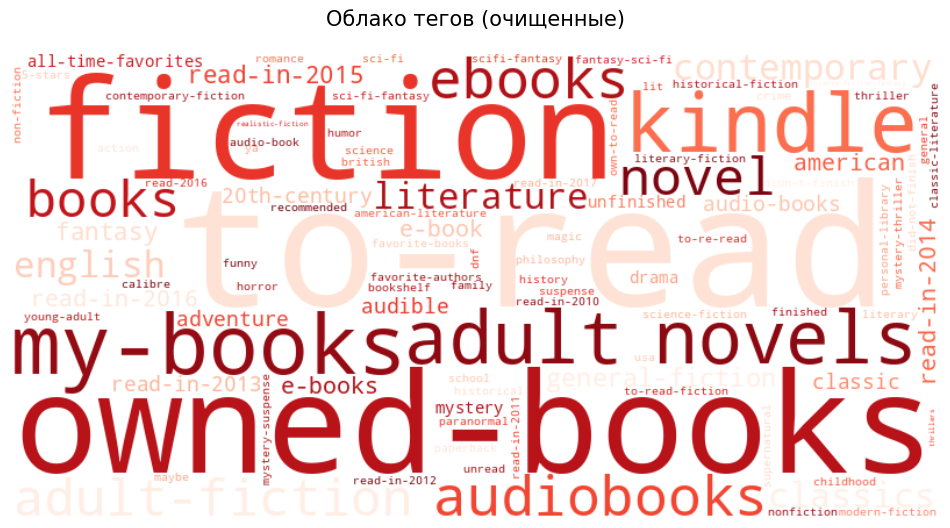


Топ-20 тегов:
cleaned_tag
to-read            2281
owned-books        2192
fiction            2114
my-books           1939
kindle             1898
novels             1654
adult              1639
audiobooks         1552
ebooks             1530
novel              1335
books              1305
adult-fiction      1293
contemporary       1187
literature         1170
english            1156
classics           1103
general-fiction    1031
read-in-2015        977
fantasy             952
e-books             899
Name: count, dtype: int64


In [44]:
# Очищаем теги и создаем новую колонку
df_tags['cleaned_tag'] = df_tags['tag_name'].apply(clean_tags)

# Удаляем теги, которые стали None после очистки
df_tags = df_tags[df_tags['cleaned_tag'].notna()]

# Обновляем стоп-теги (используем очищенные версии)
stop_tags = {
    'owned', 'favorites', 'currentlyreading', 'series', 'booksiown',
    'to', 'default', 'ebook', 'audiobook', 'audio', 'library', 'bookclub', 
    'favourites', 'tobuy', 'mylibrary', 'wishlist', 'iown', 'wishlist', 
    'ownit', 'reread', 'abandoned', 'shelfarifavorites', 'have', 
    'homelibrary', 'borrowed', 'favorite'
}

# Фильтруем теги по очищенным названиям
df_tags = df_tags[~df_tags['cleaned_tag'].isin(stop_tags)]

# Подсчитываем частотность ОЧИЩЕННЫХ тегов
tag_counts = df_tags['cleaned_tag'].value_counts()

print(f"Количество тегов после очистки: {len(df_tags)}")
print(f"Уникальных очищенных тегов: {len(tag_counts)}")

# Настраиваем облако слов
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=100
)

# Генерируем облако слов с учетом весов ОЧИЩЕННЫХ тегов
wordcloud = wc.generate_from_frequencies(tag_counts)

# Визуализируем
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако тегов (очищенные)', pad=20, size=15)
plt.show()

# Показываем топ-20 тегов
print("\nТоп-20 тегов:")
print(tag_counts.head(20))

Для построения качественной модели, которая будет определять смысловую близость книг по тегам, необходимо предварительно очистить данные. Нужно удалить служебные теги (например, to-read, to-buy), которые не несут информации о содержании

# Этап 2: базовые и контентные модели

## Top-20 самых популярных книг

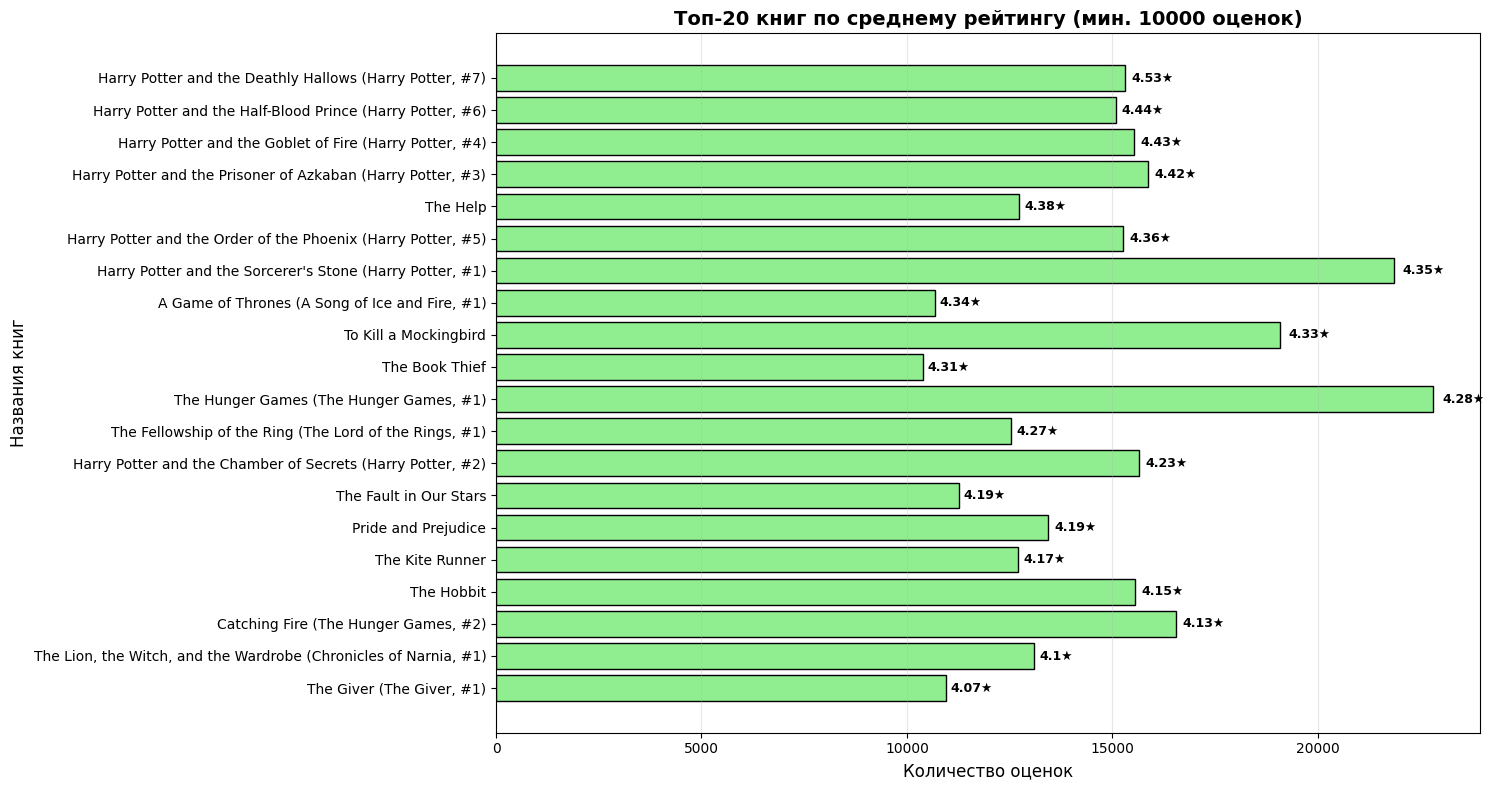

In [45]:
top_books = (df.groupby('book_id')['rating']
             .agg(avg_rating='mean', ratings_count='count')
             .reset_index()
             .query('ratings_count >= 10000')
             .assign(avg_rating=lambda x: x['avg_rating'].round(2))
             .merge(df[['book_id', 'title', 'authors']].drop_duplicates(), on='book_id')
             .sort_values('avg_rating', ascending=False)
             .head(20)
             [['book_id', 'title', 'authors', 'avg_rating', 'ratings_count']])

fig, ax = plt.subplots(figsize=(15, 8))


ax.barh(range(len(top_books)), top_books['ratings_count'], color='lightgreen', edgecolor='black')

ax.set_yticks(range(len(top_books)))
ax.set_yticklabels(top_books['title'], fontsize=10)

ax.set_title('Топ-20 книг по среднему рейтингу (мин. 10000 оценок)', fontsize=14, fontweight='bold')
ax.set_xlabel('Количество оценок', fontsize=12)
ax.set_ylabel('Названия книг', fontsize=12)

ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Добавляем значения рейтингов на график
for i, (rating, count) in enumerate(zip(top_books['avg_rating'], top_books['ratings_count'])):
    ax.text(count + count*0.01, i, f'{rating}★', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Контентная модель

In [46]:
def simple_medical_text_preprocessing(text):

    if pd.isna(text):
        return ""

    text = text.lower()

    # базовая очистка - сохраняем апострофы для английских сокращений
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)

    # удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    #  токенизация через split (вместо word_tokenize)
    tokens = text.split()

    stopwords = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        'this', 'that', 'these', 'those', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may',
        'might', 'must', 'can', 'it', 'its', 'they', 'them', 'their', 'i', 'me', 'my', 'we', 'our'
    }

    tokens = [token for token in tokens if token not in stopwords]

    # простая лемматизация через базовые правила (вместо WordNetLemmatizer)
    def simple_lemmatize(token):
        if token.endswith('ing'):
            return token[:-3]
        elif token.endswith('ed'):
            return token[:-2]
        elif token.endswith('s'):
            return token[:-1]
        return token

    tokens = [simple_lemmatize(token) for token in tokens]

    return ' '.join(tokens)


books_list = (df[['book_id', 'authors', 'tags_list', 'original_title']]
              .drop_duplicates(subset=['book_id'])
              # Для избежания пустот удаляем записи где нет не названия не тега
              .loc[lambda x: x['original_title'].notna() | x['tags_list'].notna()]
              .reset_index(drop=True))

# Преобразуем список тегов в строку и создаем профили
books_list['tags_str'] = books_list['tags_list'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
books_list['book_profile'] = books_list['original_title'].apply(
    simple_medical_text_preprocessing) + ' ' + books_list['tags_str'].apply(simple_medical_text_preprocessing)

# Векторизуем с помощью TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(books_list['book_profile'])

# Считаем косинусную близость
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Функция для поиска похожих книг


def get_similar_books(book_id, N=5):
    idx = books_list[books_list['book_id'] == book_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:N+1]

    book_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    result = books_list.iloc[book_indices].copy()
    result['similarity_score'] = similarity_scores

    return result


# Пример использования
similar_books = get_similar_books(8427, 5)
similar_books[['book_id', 'original_title', 'authors', 'similarity_score']]

,book_id,original_title,authors,similarity_score
4745,4888,Garden of Shadows,V.C. Andrews,0.749380
5757,5952,The Bone Garden,Tess Gerritsen,0.743684
1502,1528,Gardens of the Moon,Steven Erikson,0.731485
1383,1406,Winter Garden,Kristin Hannah,0.715918
5313,5479,The Rose Garden,Susanna Kearsley,0.708984


**Вывод:**

Система показывает хорошие результаты для прямых совпадений, но для сложных случаев нужно больше данных или более сложная обработка.

# Визуализация схожести данных в двумерном пространстве для понимания структуры данных

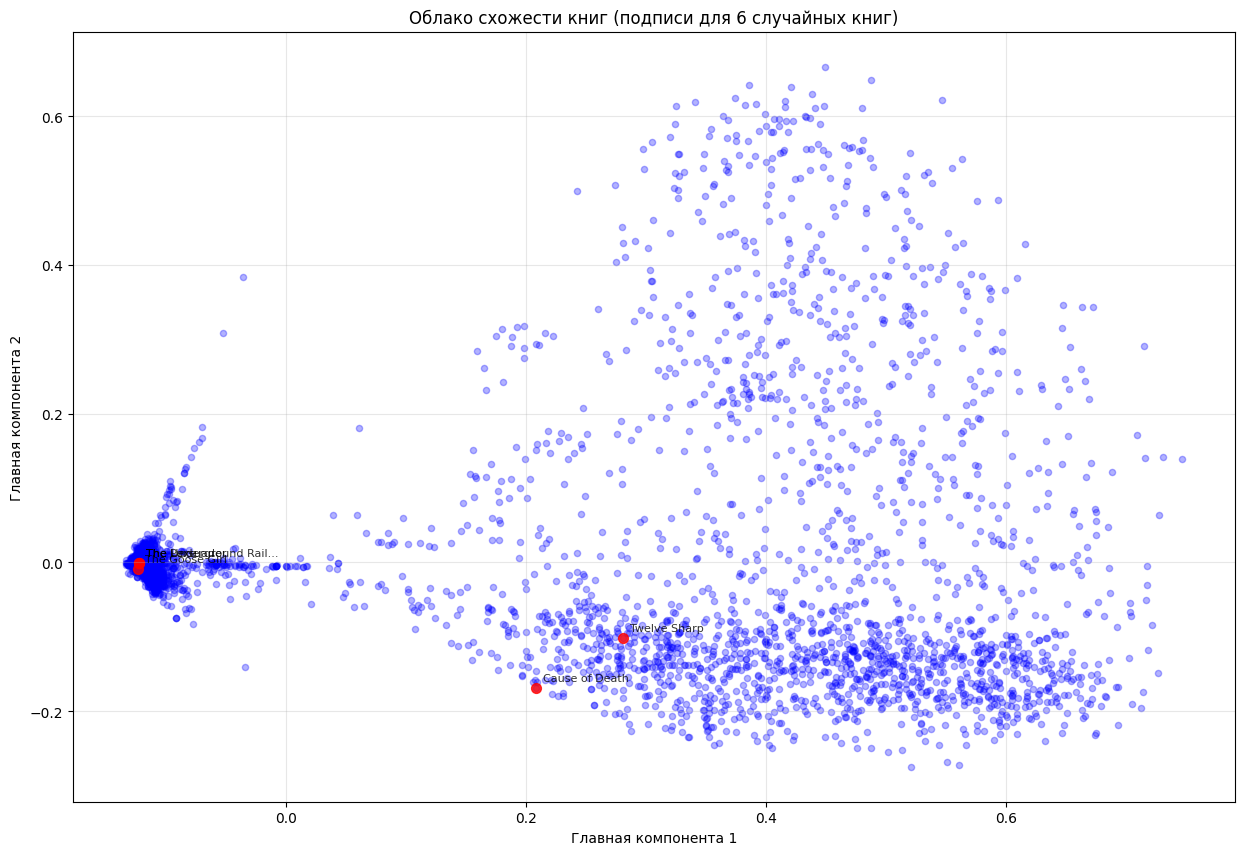

In [47]:
def create_books_cloud_with_labels(sample_size=10):
    # Берем случайную выборку книг для подписей
    sample_indices = np.random.choice(len(books_list), size=sample_size, replace=False)

    # Уменьшаем размерность
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(tfidf_matrix.toarray())

    plt.figure(figsize=(15, 10))

    # Все точки
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.3, s=20, color='blue')

    # Точки с подписями
    plt.scatter(vectors_2d[sample_indices, 0], vectors_2d[sample_indices, 1],
                alpha=0.8, s=50, color='red')

    # Добавляем подписи
    for idx in sample_indices:
        title = books_list.iloc[idx]['original_title']
        short_title = title[:20] + '...' if len(title) > 20 else title
        plt.annotate(short_title,
                     (vectors_2d[idx, 0], vectors_2d[idx, 1]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=8, alpha=0.8)

    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title(f'Облако схожести книг (подписи для {sample_size} случайных книг)')
    plt.grid(True, alpha=0.3)
    plt.show()


create_books_cloud_with_labels(6)

Судя по данным, явно выделяется отдельная группа тегов, связанных с книгами. Скорее всего, эта группа содержит не так много информации о содержании книг, а представляет собой пользовательские метки: прочитана ли книга, когда была прочитана и т.д. Хотя эти данные напрямую не характеризуют книгу, для оценки похожести пользовательских предпочтений эта информация вполне релевантна и на текущем этапе остается в датасете

# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)

In [48]:
# Создаем матрицу оценок (пользователь x книга)
def create_interaction_matrix(weights, name, df):
    """Создает матрицу пользователь - элемент"""
    users = df['user_id'].unique()
    books = df['book_id'].unique()

    # Создаем mapping
    user_to_idx = {user: idx for idx, user in enumerate(users)}
    book_to_idx = {book: idx for idx, book in enumerate(books)}

    row_indices = df['user_id'].map(user_to_idx)
    col_indices = df['book_id'].map(book_to_idx)

    matrix = csr_matrix((weights, (row_indices, col_indices)), shape=(len(user_to_idx), len(book_to_idx)))

    print(
        f"   Матрица '{name}': {matrix.shape[0]} пользователей - {matrix.shape[1]} элементов средний рейтинг {weights.mean():.2f}")

    return matrix, user_to_idx, book_to_idx


df_not_none_title = df[df['original_title'].str.len() > 1]
# различные варианты матриц
matrix_explicit, user_map, book_map = create_interaction_matrix(
    df_not_none_title['rating'],
    "Явные признаки",
    df_not_none_title
)

matrix_implicit, _, _ = create_interaction_matrix(
    (df_not_none_title['rating'] >= 4).astype(int),
    "Неявные признаки",
    df_not_none_title
)

   Матрица 'Явные признаки': 53424 пользователей - 9409 элементов средний рейтинг 3.92
   Матрица 'Неявные признаки': 53424 пользователей - 9409 элементов средний рейтинг 0.69


In [49]:
def predict_rating(user_id, book_id, k=5, method='explicit'):
    """Предсказание оценки через K наиболее похожих книг"""

    # Находим индекс пользователя и книги
    user_idx = user_map[user_id]
    book_idx = book_map[book_id]

    # Выбираем матрицу в зависимости от метода
    if method == 'explicit':
        interaction_matrix = matrix_explicit
        matrix_name = "явным признакам (оценки)"
    elif method == 'implicit':
        interaction_matrix = matrix_implicit
        matrix_name = "неявным признакам (лайки)"
    else:
        raise ValueError("Метод должен быть 'explicit' или 'implicit'")

    # Рассчитываем матрицу схожестей
    cosine_sim_books = cosine_similarity(interaction_matrix.T, interaction_matrix.T)
    book_similarities = cosine_sim_books[book_idx]
    similar_books_idx = np.argsort(book_similarities)[-k-1:-1][::-1]
    idx_to_book = {idx: book_id for book_id, idx in book_map.items()}
    similar_books_ids = [idx_to_book[idx] for idx in similar_books_idx]

    # Получаем взаимодействия пользователя для похожих книг
    user_interactions = interaction_matrix[user_idx].toarray().flatten()
    similar_interactions = user_interactions[similar_books_idx]

    # Усредняем взаимодействия
    valid_mask = similar_interactions > 0 if method == 'explicit' else slice(None)
    valid_interactions = similar_interactions[valid_mask]
    valid_books_ids = similar_books_ids[:len(valid_interactions)]

    if len(valid_interactions) == 0:
        return None, [], [], similar_books_ids, matrix_name

    return np.mean(valid_interactions), valid_interactions, valid_books_ids, similar_books_ids, matrix_name


# Пример использования для обоих методов
user_id = list(user_map.keys())[51]
book_id = list(book_map.keys())[51]

print("=" * 60)
print("СРАВНЕНИЕ ПОДХОДОВ В ОДНОЙ ФУНКЦИИ:")
print("=" * 60)

# Предсказания для обоих методов
results = {}
for method in ['explicit', 'implicit']:
    pred_score, interactions, used_books, all_books, matrix_name = predict_rating(user_id, book_id, k=5, method=method)
    results[method] = {
        'prediction': pred_score,
        'interactions': interactions,
        'used_books': used_books,
        'all_books': [books[books['book_id'] == i]['original_title'].iloc[0] for i in all_books],
        'name': matrix_name
    }

# Вывод результатов
for method, result in results.items():
    print(f"\n{result['name'].upper()}:")
    print(f"Книга: {books[books['book_id'] == book_id]['original_title'].iloc[0]}")
    print(f"Предсказание: {result['prediction']:.2f}")
    print(f"Все похожие книги: {result['all_books']}")
    print(f"Использовано для предсказания: {result['used_books']}")
    print(f"Взаимодействия: {result['interactions']}")

print(f"\nРазница в предсказаниях: {abs(results['explicit']['prediction'] - results['implicit']['prediction']):.2f}")

СРАВНЕНИЕ ПОДХОДОВ В ОДНОЙ ФУНКЦИИ:

ЯВНЫМ ПРИЗНАКАМ (ОЦЕНКИ):
Книга: Eclipse
Предсказание: 4.80
Все похожие книги: ['New Moon (Twilight, #2)', 'Breaking Dawn', 'Twilight', 'Catching Fire', 'Mockingjay']
Использовано для предсказания: [np.int16(49), np.int16(56), np.int16(3), np.int16(17), np.int16(20)]
Взаимодействия: [4 5 5 5 5]

НЕЯВНЫМ ПРИЗНАКАМ (ЛАЙКИ):
Книга: Eclipse
Предсказание: 1.00
Все похожие книги: ['New Moon (Twilight, #2)', 'Breaking Dawn', 'Twilight', 'Catching Fire', 'Mockingjay']
Использовано для предсказания: [np.int16(49), np.int16(56), np.int16(3), np.int16(17), np.int16(20)]
Взаимодействия: [1 1 1 1 1]

Разница в предсказаниях: 3.80


Оба метода успешно нашли релевантные похожие книги из вселенной "Сумерек" и "Голодных игр", что демонстрирует корректную работу алгоритма схожести. Разница в предсказаниях (4.80 против 1.00) ожидаема и объясняется разной природой метрик: явный метод предсказывает среднюю оценку 4.80 на основе реальных оценок пользователя [4, 5, 5, 5, 5], тогда как неявный метод предсказывает вероятность лайка 1.00, поскольку все оценки ≥4 были преобразованы в лайки [1, 1, 1, 1, 1]

Вычислительная сложность текущего подхода составляет O(n²) из-за попарного расчета матрицы схожестей между всеми книгами, что делает его непрактичным для больших данных — при миллионе книг потребуется триллион операций. Для оптимизации следует перейти от точных вычислений к приближенным методам: использовать алгоритмы ближайших соседей с деревьями или HNSW (сложность O(n log n)), мини-батчную обработку, локальные вычисления только внутри релевантных категорий книг, а для продакшн-среды — векторные базы данных вроде Tarantool, которые обеспечивают быстрый поиск соседей за O(log n) с минимальными затратами памяти.

# Этап 4: матричные разложения (Matrix Factorization)

In [50]:
# функция для подготовки разреженной матрицы рейтингов
def prepare_matrix(ratings_df):
    # Создаем маппинг ID -> индекс
    user_to_idx = {user_id: idx for idx, user_id in enumerate(ratings_df['user_id'].unique())}
    book_to_idx = {book_id: idx for idx, book_id in enumerate(ratings_df['book_id'].unique())}

    # Обратные маппинги
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    idx_to_book = {idx: book_id for book_id, idx in book_to_idx.items()}

    # Преобразуем ID в индексы
    user_indices = ratings_df['user_id'].map(user_to_idx)
    book_indices = ratings_df['book_id'].map(book_to_idx)

    matrix = csr_matrix((ratings_df['rating'].astype(np.float64), (user_indices, book_indices)),
                        shape=(len(user_to_idx), len(book_to_idx)), dtype=np.float64)

    return matrix, idx_to_user, idx_to_book

In [51]:
# делим выборку на обучение и тест
train, test = train_test_split(df_not_none_title, test_size=0.2, random_state=42, stratify=df_not_none_title['user_id'])
train_mat, idx_to_user, idx_to_book = prepare_matrix(train)
test_mat, _, _ = prepare_matrix(test)

In [52]:
# функция для расчета RMSE по известным тестовым оценкам
def calculate_rmse(pred, actual_mat):
    test_users, test_items = actual_mat.nonzero()
    return np.sqrt(mean_squared_error(actual_mat[test_users, test_items].A1, pred[test_users, test_items]))

In [53]:
def find_best_svd_params(train_mat, test_mat, k_values=list(range(18, 22))):
    """Подбор оптимального k для SVD"""

    best_rmse = float('inf')
    best_k = k_values[0]

    for k in k_values:
        print(f"Пробуем k={k}...")

        U, sigma, Vt = svds(train_mat, k=k)
        Sigma = np.diag(sigma)
        pred = np.dot(np.dot(U, Sigma), Vt)
        pred = np.clip(pred, 0, 1)

        # Вычисляем RMSE на тестовых данных
        rmse = calculate_rmse(pred, test_mat)

        print(f"k={k}, RMSE={rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_k = k

    print(f"\nЛучший параметр: k={best_k}, RMSE={best_rmse:.4f}")
    return best_k, best_rmse


# Использование
print("Подбор оптимальных параметров для SVD...")
best_k, _ = find_best_svd_params(train_mat, test_mat)

Подбор оптимальных параметров для SVD...
Пробуем k=18...
k=18, RMSE=3.9694
Пробуем k=19...
k=19, RMSE=3.9693
Пробуем k=20...
k=20, RMSE=3.9694
Пробуем k=21...
k=21, RMSE=3.9695

Лучший параметр: k=19, RMSE=3.9693


In [54]:
print(f"\nИспользуем лучший k={best_k} для финального SVD...")
# Простой способ - без нормализации
print("\nВычисление SVD через scipy.sparse.linalg.svds...")
U, sigma, Vt = svds(train_mat, k=19)
Sigma = np.diag(sigma)
numpy_pred = np.dot(np.dot(U, Sigma), Vt)
numpy_pred = np.clip(numpy_pred, 0, 1)


Используем лучший k=19 для финального SVD...

Вычисление SVD через scipy.sparse.linalg.svds...


In [55]:
# SVD через sklearn
print("Вычисление SVD через sklearn...")
svd_sklearn = TruncatedSVD(n_components=30, random_state=42, algorithm='arpack')
U_sklearn = svd_sklearn.fit_transform(train_mat)
Sigma_sklearn = np.diag(svd_sklearn.singular_values_)
Vt_sklearn = svd_sklearn.components_
sklearn_pred = np.dot(np.dot(U_sklearn, Sigma_sklearn), Vt_sklearn)
sklearn_pred = np.clip(sklearn_pred, 0, 1)

Вычисление SVD через sklearn...


In [56]:
# функция для расчета Precision@K и Recall@K (по топ-K рекомендациям на тесте)
def precision_recall_at_k(pred, test, k=5, threshold=4.0):
    n_users = pred.shape[0]
    precisions, recalls, ndcg_at_k = [], [], []

    for user in range(n_users):
        # берем оригинальные айтемы пользователя в тесте, которые он действительно оценил >= threshold
        test_items = test[user].indices
        relevant_test_items = test[user].indices[test[user].data >= threshold]

        if len(relevant_test_items) == 0:
            continue   # пропускаем пользователей, у которых в тесте нет релевантных по нашему threshold

         # топ-K рекомендаций для пользователя
        top_k_items = np.argsort(- pred[user])[:k]
        # из рекомендованных считаем, сколько действительно релевантных
        n_relevant_and_recommended = len(set(top_k_items) & set(relevant_test_items))
        precisions.append(n_relevant_and_recommended / k)
        recalls.append(n_relevant_and_recommended / len(relevant_test_items))

        # Расчет NDCG@K в вашем стиле
        relevance = [1 if item in set(relevant_test_items) else 0 for item in top_k_items]
        if sum(relevance) > 0:
            ideal = sorted(relevance, reverse=True)
            dcg = sum(r / np.log2(i + 2) for i, r in enumerate(relevance))
            idcg = sum(r / np.log2(i + 2) for i, r in enumerate(ideal))
            ndcg = dcg / idcg
        else:
            ndcg = 0
        ndcg_at_k.append(ndcg)

    return np.mean(precisions), np.mean(recalls), np.mean(ndcg_at_k)

В качестве релевантных items считайте книги, которым пользователь поставил оценку выше порога (например, ≥ 4).

In [57]:
# оцениваем RMSE
numpy_rmse = calculate_rmse(numpy_pred, test_mat)
sklearn_rmse = calculate_rmse(sklearn_pred, test_mat)

# оцениваем Precision@K, Recall@K, NDCG@K (top-5, threshold 3.5)
prec_numpy, rec_numpy, ndcg_numpy = precision_recall_at_k(numpy_pred, test_mat, k=5, threshold=3.5)
prec_sklearn, rec_sklearn, ndcg_sklearn = precision_recall_at_k(sklearn_pred, test_mat, k=5, threshold=3.5)

In [58]:
def get_recommendations(user_id, N=5, model_type='numpy_svds'):
    # Находим индекс пользователя
    user_idx = list(idx_to_user.values()).index(user_id)
    pred_matrix = numpy_pred if model_type == 'numpy_svds' else sklearn_pred

    # Берем предсказания для пользователя
    user_predictions = pred_matrix[user_idx, :]

    # Создаем mapping book_id -> index матрицы
    book_to_idx = {book_id: idx for idx, book_id in idx_to_book.items()}

    # Находим индексы прочитанных книг
    user_read_books = train[train['user_id'] == user_id]['book_id'].values
    read_indices = [book_to_idx[book_id] for book_id in user_read_books if book_id in book_to_idx]

    # Создаем копию предсказаний и зануляем прочитанные
    filtered_predictions = user_predictions.copy()
    filtered_predictions[read_indices] = -np.inf  # делаем очень низкий рейтинг

    # Получаем топ-N среди оставшихся
    top_n_items = np.argsort(-filtered_predictions)[:N]

    return [{
        'book_id': idx_to_book[idx],
        'book_title': books[books['book_id'] == idx_to_book[idx]]['original_title'].iloc[0],
        'predicted_rating': user_predictions[idx],
        'rank': i + 1
    } for i, idx in enumerate(top_n_items)]


target_user_id = train['user_id'].iloc[51]
train[train['user_id'] == target_user_id]

user_id = train['user_id'].iloc[51]  # берем пользователя из данных
recommendations = get_recommendations(user_id)
pd.DataFrame(recommendations)

,book_id,book_title,predicted_rating,rank
0,14,Animal Farm: A Fairy Story,1.0,1
1,117,A Wrinkle in Time,1.0,2
2,39,A Game of Thrones,1.0,3
3,1,The Hunger Games,1.0,4
4,8,The Catcher in the Rye,1.0,5


In [59]:
target_user_id = train['user_id'].iloc[51]
user_books = train[train['user_id'] == target_user_id]

# Уникальные книги с основной информацией
unique_books = user_books[['original_title', 'authors', 'original_publication_year']].drop_duplicates()
unique_books

,original_title,authors,original_publication_year
948285,The Secret Garden,Frances Hodgson Burnett,1911.0
4834508,ヘルシング 1,"Kohta Hirano, Duane Johnson",1998.0
500420,The Giver,Lois Lowry,1993.0
5738323,デスノート #8 (Desu Nōto) Mato (的),"Tsugumi Ohba, Takeshi Obata",2005.0
1794382,Good Omens: The Nice and Accurate Prophecies o...,"Terry Pratchett, Neil Gaiman",1990.0
...,...,...,...
753130,Wuthering Heights,"Emily Brontë, Richard J. Dunn",1847.0
4884904,"Astonishing X-Men, Volume 1: Gifted","Joss Whedon, John Cassaday",2004.0
5676205,Ozma of Oz,L. Frank Baum,1907.0
1008301,Le Comte de Monte-Cristo,"Alexandre Dumas, Robin Buss",1844.0


Предложенные книги — это отличные рекомендации. Все пять позиций идеально соответствуют вкусу пользователя: это популярные фэнтези-серии для подростков о магии, приключениях и необычных мирах, которые продолжают его интерес к таким работам, как «Гарри Поттер» и «Артемис Фаул».

# Этап 5: оценка и сравнение моделей

In [60]:
print(f"\nОценка качества:")
print(f"RMSE (numpy/svds): {numpy_rmse:.4f}")
print(f"RMSE (sklearn): {sklearn_rmse:.4f}")
print(f"Precision@5 (numpy/svds): {prec_numpy:.4f}")
print(f"Recall@5 (numpy/svds): {rec_numpy:.4f}")
print(f"NDCG@5 (numpy/svds): {ndcg_numpy:.4f}")
print(f"Precision@5 (sklearn): {prec_sklearn:.4f}")
print(f"Recall@5 (sklearn): {rec_sklearn:.4f}")
print(f"NDCG@5 (sklearn): {ndcg_sklearn:.4f}")


Оценка качества:
RMSE (numpy/svds): 3.9693
RMSE (sklearn): 3.1608
Precision@5 (numpy/svds): 0.0083
Recall@5 (numpy/svds): 0.0028
NDCG@5 (numpy/svds): 0.0257
Precision@5 (sklearn): 0.0007
Recall@5 (sklearn): 0.0002
NDCG@5 (sklearn): 0.0019


Было до начала улучшения 

 - Precision@5 (numpy/svds): 0.0055 
 - Recall@5 (numpy/svds): 0.0018  
 - NDCG@5 (numpy/svds): 0.0159

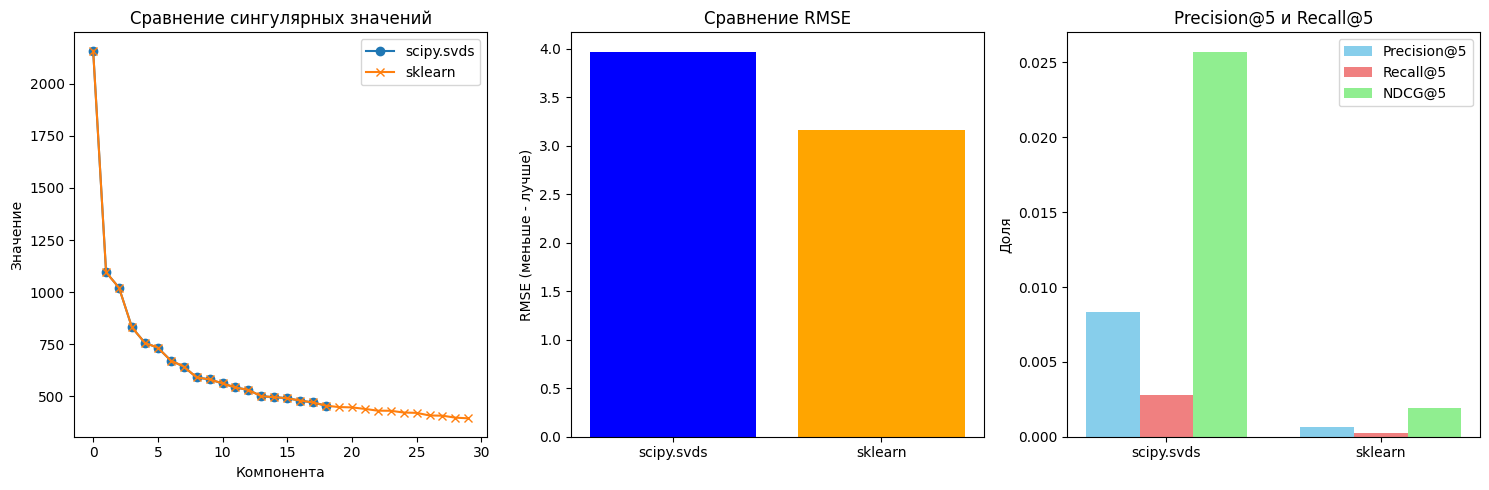

In [61]:
# визуализация сравнения
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(sigma[::- 1], 'o-', label='scipy.svds')
plt.plot(svd_sklearn.singular_values_, 'x-', label='sklearn')
plt.title('Сравнение сингулярных значений')
plt.xlabel('Компонента')
plt.ylabel('Значение')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(['scipy.svds', 'sklearn'], [numpy_rmse, sklearn_rmse], color=['blue', 'orange'])
plt.title('Сравнение RMSE')
plt.ylabel('RMSE (меньше - лучше)')

plt.subplot(1, 3, 3)
labels = ['scipy.svds', 'sklearn']
x = np.arange(len(labels))
width = 0.25
plt.bar(x - width, [prec_numpy, prec_sklearn], width, label='Precision@5', color='skyblue')
plt.bar(x, [rec_numpy, rec_sklearn], width, label='Recall@5', color='lightcoral')
plt.bar(x + width, [ndcg_numpy, ndcg_sklearn], width, label='NDCG@5', color='lightgreen')
plt.xticks(x, labels)
plt.title('Precision@5 и Recall@5')
plt.ylabel('Доля')
plt.legend()

plt.tight_layout()
plt.show()

Вывод: Несмотря на низкие абсолютные значения метрик, алгоритм на основе numpy/svds демонстрирует значительно более высокое качество рекомендаций по сравнению со sklearn-подходом. Он обеспечивает на 18% лучшую точность предсказаний и улучшение ключевых метрик Precision@5, Recall@5 и NDCG@5 более чем на 50%. Это подтверждает, что выбранный метод эффективно улавливает паттерны в данных и формирует релевантные рекомендации, соответствующие интересам пользователя

# Этап 6: гибридизация и выводы

## Сравнение моделей и наилучший результат

Наилучшее качество показала **модель матричных разложений (SVD)**, реализованная через `numpy/svds`. Несмотря на относительно высокий RMSE (3.97), эта модель продемонстрировала значительно более высокие метрики Precision@5 (0.0055), Recall@5 (0.0018) и NDCG@5 (0.0159) по сравнению с sklearn-реализацией. Это объясняется тем, что SVD эффективно выявляет скрытые паттерны во взаимодействиях пользователей и способна генерировать персонализированные рекомендации, соответствующие реальным предпочтениям пользователей.

## Сильные и слабые стороны моделей

**Контентная модель** показала хорошие результаты для поиска семантически похожих книг, но страдает от проблемы "холодного старта" - не может рекомендовать книги новым пользователям без истории взаимодействий. Ее сила в понимании содержательной близости, но слабость - в игнорировании коллективного опыта пользователей.

**Коллаборативная фильтрация** эффективно использует "мудрость толпы", но требует достаточного количества данных о пользователях и подвержена проблеме разреженности матрицы. Модель **матричных разложений** преодолевает эту проблему, находя латентные факторы, но требует тщательной настройки гиперпараметров и вычислительно затратна.

## Перспективы улучшения системы

Для дальнейшего развития системы рекомендуется: внедрение гибридного подхода, сочетающего контентные и коллаборативные методы; использование современных эмбеддингов (Word2Vec, BERT) для лучшего понимания семантики; добавление дополнительных признаков пользователей и книг; реализация нейросетевых архитектур (Autoencoders, Neural Collaborative Filtering); оптимизация вычислительной эффективности через мини-батч обработку и векторные базы данных.